# Make more Part 3:
- Activations
- Gradients
- Batch norms
- Goal: How they work, visualise them to better understand how to apply them on more complex networks like RNNs, LSTM and Transformers

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
# build vocab of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# building the dataset
def build_dataset(words):
    block_size = 3
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [6]:
# train, val and test splits:
import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

##  Notes: Made inital weights small, and multiplied initial biases by 0 to make it uniform. This helps making sure logits are closer to reality. Without it (just random weigths and biases), network may give huge logits to start. We don't zero out weights because , the small entropy helps with tie breaking when we multiply weights by a super small value like 0.01
- W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.01 # make initial weights small
- b2 = torch.randn(vocab_size, generator=g) * 0 # for uniform bias


In [38]:
# Defining MLP
n_embed = 10 # embedding dimensions
n_hidden = 200 # number of neurons in hidden layer
block_size = 3 # context: How many characters do we take to predit the next character
vocab_size = 27

# MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) *0.2 # make initial weights small
b1 = torch.randn(n_hidden, generator=g) * 0.01 # entropy for initial biases
W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.01 # make initial weights small
b2 = torch.randn(vocab_size, generator=g) * 0 # for uniform bias

params = [C, W1, b1, W2, b2]
print(f'number of parameters: {sum(p.nelement() for p in params)}') # 11K params
for p in params:
    p.requires_grad = True

number of parameters: 11897


In [39]:
max_steps = 200000
batch_size = 32
losses = []

In [40]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
   
    # LR update schedule
    lr  = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data+= -lr*p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())


      0/ 200000: 3.3215
  10000/ 200000: 2.7829
  20000/ 200000: 2.6220
  30000/ 200000: 2.2197
  40000/ 200000: 2.0527
  50000/ 200000: 2.0722
  60000/ 200000: 2.1336
  70000/ 200000: 2.4491
  80000/ 200000: 2.4489
  90000/ 200000: 2.2914
 100000/ 200000: 2.1584
 110000/ 200000: 1.6493
 120000/ 200000: 1.9318
 130000/ 200000: 1.7062
 140000/ 200000: 1.8691
 150000/ 200000: 2.4337
 160000/ 200000: 2.2667
 170000/ 200000: 1.9697
 180000/ 200000: 1.6422
 190000/ 200000: 1.6970


# What is tanh doing here?
![Tanh Visualisation](../plots/activations_tanh_problematic.png)
- Most values are either -1 or 1. This means, in backprop, the gradients are effectively being set to 0. So the model isn't learning anything most of the time
- Visualizing how active the neurons are for first pass. If the entire column is white, that means that's a dead neuron and doesn't learn anything. Showing a plot for 32 samples and 200 neurons

    - ![Neuron Activity](../plots/neuron_activity_tanh_step1.png)

(array([171., 169., 179., 142., 153., 153., 147., 115., 111., 138.,  98.,
        109., 107., 104., 118.,  99., 121.,  97., 124., 114., 110.,  96.,
        105.,  87.,  91., 103.,  81., 116.,  97.,  94., 119., 119., 119.,
        100., 101., 121., 104., 125., 105., 120., 126., 124., 128., 145.,
        165., 180., 181., 196., 216., 257.]),
 array([-9.99019325e-01, -9.59047002e-01, -9.19074678e-01, -8.79102355e-01,
        -8.39130032e-01, -7.99157709e-01, -7.59185386e-01, -7.19213063e-01,
        -6.79240739e-01, -6.39268416e-01, -5.99296093e-01, -5.59323770e-01,
        -5.19351447e-01, -4.79379123e-01, -4.39406800e-01, -3.99434477e-01,
        -3.59462154e-01, -3.19489831e-01, -2.79517508e-01, -2.39545184e-01,
        -1.99572861e-01, -1.59600538e-01, -1.19628215e-01, -7.96558917e-02,
        -3.96835685e-02,  2.88754702e-04,  4.02610779e-02,  8.02334011e-02,
         1.20205724e-01,  1.60178047e-01,  2.00150371e-01,  2.40122694e-01,
         2.80095017e-01,  3.20067340e-01,  3.60039

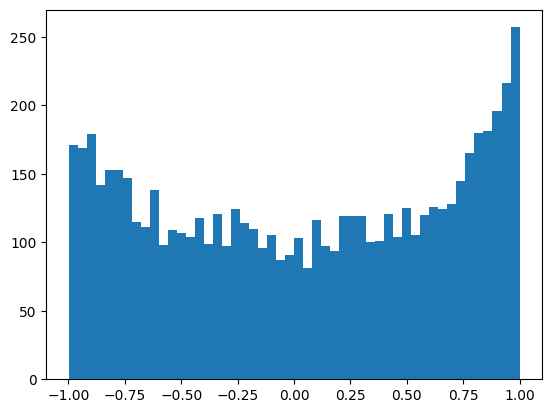

In [35]:
## visualizing activations:
plt.hist(h.view(-1).tolist(), bins=50)

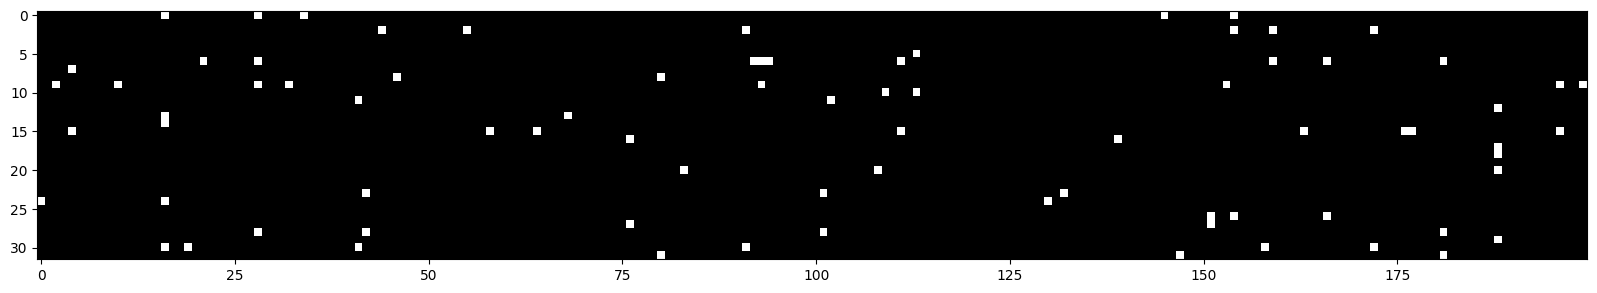

In [36]:
## visualising "active" neuron regions:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99 , cmap = 'gray', interpolation = 'nearest') # white if tanh is in flat region (-1 or 1) in this case, the gradients are 0
# after adjusting the weights, the neurons are no longer in flat region, so the gradients are not 0

(array([  1.,   1.,   1.,   2.,   5.,   7.,   9.,  10.,  19.,  29.,  47.,
         60.,  86.,  90., 131., 157., 192., 266., 251., 303., 347., 376.,
        439., 373., 395., 429., 346., 339., 279., 275., 241., 201., 151.,
        146.,  81.,  85.,  80.,  44.,  27.,  27.,  17.,   6.,   8.,   5.,
          8.,   3.,   1.,   1.,   1.,   2.]),
 array([-3.80996466, -3.64867496, -3.48738525, -3.32609555, -3.16480585,
        -3.00351615, -2.84222645, -2.68093675, -2.51964705, -2.35835734,
        -2.19706764, -2.03577794, -1.87448824, -1.71319854, -1.55190884,
        -1.39061913, -1.22932943, -1.06803973, -0.90675003, -0.74546033,
        -0.58417063, -0.42288093, -0.26159122, -0.10030152,  0.06098818,
         0.22227788,  0.38356758,  0.54485728,  0.70614698,  0.86743669,
         1.02872639,  1.19001609,  1.35130579,  1.51259549,  1.67388519,
         1.83517489,  1.9964646 ,  2.1577543 ,  2.319044  ,  2.4803337 ,
         2.6416234 ,  2.8029131 ,  2.9642028 ,  3.12549251,  3.28678221,
 

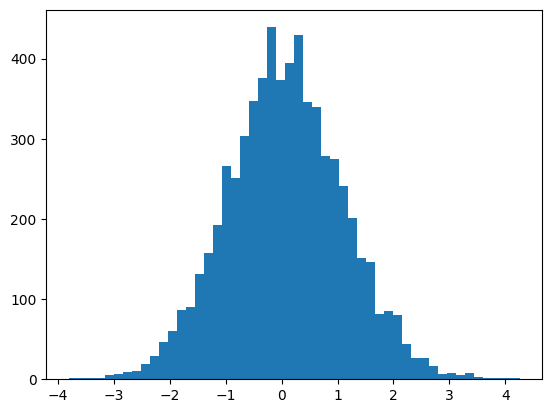

In [37]:
## looking at distribution of pre-activations
plt.hist(hpreact.view(-1).tolist(), bins=50)

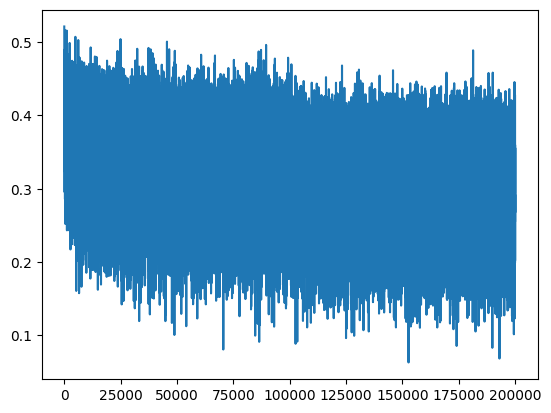

In [41]:
plt.plot(losses)

# @torch.no_grad()
- Disable gradient tracking
- Pytorch won't need to compute and maintain a graph 

In [42]:
@torch.no_grad() # When we want to disable gradient tracking
def split_loss(split:str) -> tuple[str, float]:
    X,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test':(Xtest, Ytest)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())
split_loss('train'), split_loss('val')


(('train', 1.989437460899353), ('val', 2.3274142742156982))

In [43]:
## Sampling from the model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20): # want to sample 20 words
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) ## automatically makes sure there are no overflows
        ix = torch.multinomial(probs,num_samples = 1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0: # break till we generated a '.'
            break
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
reet.
khalaysie.
mahnen.
amerynci.
aqui.
ner.
kiah.
maiiyan.
legy.
dham.
joce.
quintis.
lilea.
jadique.
jerma.
jarisi.
jace.


# Preserving input distribution
- When we do out Wx+b, we end up modifying the gaussian a bit so we end up changing our input distribution. 
- When we multiply the weights by a large number, the spead/variance increases. When we multiply it by a small number, it decreases.
- We don't want to activations to expand to infinity or shrink down to 0. We want them well behaved
- To keep the gaussian simialar to input (sd=1), we can divide the weights by square root of fan_in (W.shape[0])
- Because tanh is a squashing function, we will also need something called a gain on top of squareroot of fan in. (This is 5/3) for kaiming initialisaiton
- Using standar initialisation methods like this would help make our network more generalisable without tweaking it everytime for different use cases. 
- We can also use things like residual layers, batch norm, layer norm, group norm to help fight the squashing from tanh so initialisation isn't super important
- Can also use better optimisers like RMSProp and Adam.

tensor(-0.0116) tensor(0.9867)
tensor(0.0010) tensor(1.0030)


(array([2.33961522e-05, 7.01884565e-05, 4.67923043e-05, 2.33961522e-04,
        2.80753826e-04, 3.50942282e-04, 5.38111500e-04, 1.05282685e-03,
        1.98867293e-03, 2.55018058e-03, 5.10036117e-03, 8.37582247e-03,
        1.07388338e-02, 1.74301334e-02, 2.53614289e-02, 3.81357280e-02,
        5.66186882e-02, 8.09272903e-02, 1.12675869e-01, 1.54835735e-01,
        2.07828020e-01, 2.59954647e-01, 3.27101603e-01, 3.76607861e-01,
        4.17153393e-01, 4.37063518e-01, 4.23329977e-01, 3.79392003e-01,
        3.27850280e-01, 2.68260281e-01, 2.08857450e-01, 1.59023646e-01,
        1.13564923e-01, 8.46472785e-02, 5.62911421e-02, 3.93523279e-02,
        2.70225557e-02, 1.71493795e-02, 1.14173223e-02, 7.67393791e-03,
        4.60904197e-03, 3.25206515e-03, 1.80150372e-03, 1.02943069e-03,
        7.01884565e-04, 4.91319195e-04, 1.63773065e-04, 1.87169217e-04,
        4.67923043e-05, 7.01884565e-05]),
 array([-5.4550128 , -5.24130244, -5.02759209, -4.81388173, -4.60017138,
        -4.38646102, 

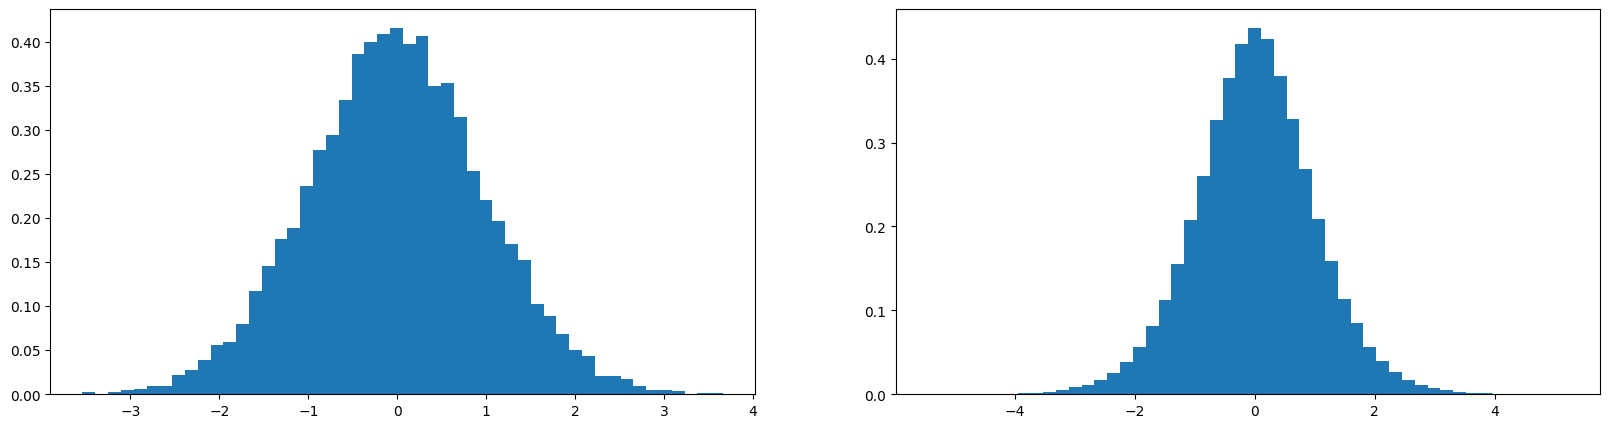

In [ ]:
## example:
x = torch.randn(1000,10)
w = torch.randn(10, 200) # sd(y) = 3, sd(x) = 1
w = torch.randn(10, 200)/10**0.5 # sd(x)~1, sd(y)~1

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True)

In [48]:
# Defining MLP
n_embed = 10 # embedding dimensions
n_hidden = 200 # number of neurons in hidden layer
block_size = 3 # context: How many characters do we take to predit the next character
vocab_size = 27
fan_in = n_embed*block_size
# MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) *(5/3)*((fan_in)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 # entropy for initial biases
W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.01 # make initial weights small
b2 = torch.randn(vocab_size, generator=g) * 0 # for uniform bias

params = [C, W1, b1, W2, b2]
print(f'number of parameters: {sum(p.nelement() for p in params)}') # 11K params
for p in params:
    p.requires_grad = True

number of parameters: 11897


In [49]:
max_steps = 200000
batch_size = 32
losses = []

In [50]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
   
    # LR update schedule
    lr  = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data+= -lr*p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 200000: 3.2627
  10000/ 200000: 2.3302
  20000/ 200000: 2.5530
  30000/ 200000: 2.4790
  40000/ 200000: 2.4401
  50000/ 200000: 2.2172
  60000/ 200000: 2.3065
  70000/ 200000: 2.6971
  80000/ 200000: 2.4548
  90000/ 200000: 1.9440
 100000/ 200000: 2.0337
 110000/ 200000: 2.0856
 120000/ 200000: 2.3541
 130000/ 200000: 1.8029
 140000/ 200000: 1.6543
 150000/ 200000: 1.9746
 160000/ 200000: 2.1210
 170000/ 200000: 2.4436
 180000/ 200000: 2.0352
 190000/ 200000: 2.2382


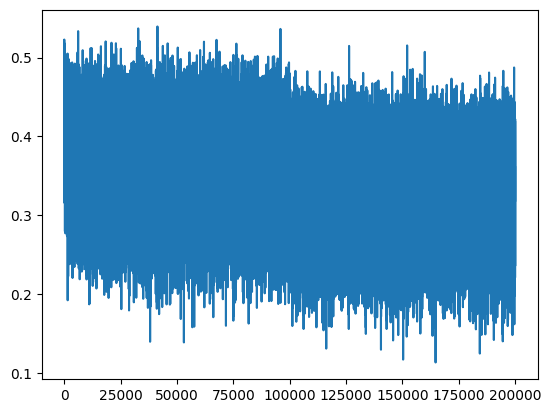

In [51]:
plt.plot(losses)

In [52]:
split_loss('train'), split_loss('val')

(('train', 2.128757953643799), ('val', 2.421492338180542))

# Batch Normalisation
- Paper: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf
- Gist: Take the hidden states and normalise them to be gaussian
- Normalising them just before they enter the activation functions (normalise pre activations (WX+B))
- We only want it to be roughly gaussian but only at initialisation. We want it to move around a bit during training and we want to gradients to guide how much it moves around
- When using batch norm, the samples now depend on all other samples in the batch. So there's jittering in h and logits (movement in values of samples). This might be undesireable but works well for training NN. Beacause this works as a regularizer. It works kind of like data augmentation/padding for samples which makes it harder for NN to overfit on these samples. 
- If we want to avoid this property of batch norm, we can use other techniques like Layer Norm, Instance Norm and Group Norm
- When using Batch Norm, we don't need bias in the layer before it as it gets subtracted when you do batch norm. We can just use batchbias as the bias for batch norm and not the bias in the layer before it
- **torch.batchnorm1d**: For large batch size, when you calculate estimated mean and std, you would get similar results so you can keep momentum to a higher value like **0.1** and for smaller batch sizes, the mean and std would change a lot so you should use a small momentum (beacause a high momentum would change it too much) like **0.001**
- ***TRY TO AVOID BATCH NORMALISATION AS MUCH AS POSSIBLE***
- Still super important as it was the first technique that allowed training super deep NNs

In [79]:
# Defining MLP
n_embed = 10 # embedding dimensions
n_hidden = 200 # number of neurons in hidden layer
block_size = 3 # context: How many characters do we take to predit the next character
vocab_size = 27
fan_in = n_embed*block_size
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bmean_running = torch.zeros((1,n_hidden))
bstd_running = torch.ones((1,n_hidden))
# MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) *(5/3)*((fan_in)**0.5)
#b1 = torch.randn(n_hidden, generator=g) * 0.01 # entropy for initial biases
W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.01 # make initial weights small
b2 = torch.randn(vocab_size, generator=g) * 0 # for uniform bias

params = [C, W1, W2, b2, bngain, bnbias]
print(f'number of parameters: {sum(p.nelement() for p in params)}') # 11K params
for p in params:
    p.requires_grad = True

number of parameters: 12097


In [80]:
max_steps = 200000
batch_size = 32
losses = []

In [ ]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    
    # --- Batch Norm Layer ----
    bmeani = hpreact.mean(dim=0, keepdim=True)
    bstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bmeani)/bstdi) + bnbias
    
    with torch.no_grad():
        bmean_running = bmean_running * 0.999 + bmeani * 0.001
        bstd_running = bstd_running * 0.999 + bstdi * 0.001
        
    # ---- Non Linearity ----
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # --- backward pass ---
    for p in params:
        p.grad = None
    loss.backward()
   
    # --- LR update schedule ---
    lr  = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data+= -lr*p.grad
    
    # --- track stats ---
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 200000: 3.3081
  10000/ 200000: 2.1704
  20000/ 200000: 2.3079
  30000/ 200000: 1.8569
  40000/ 200000: 2.0600
  50000/ 200000: 2.1848
  60000/ 200000: 1.9850
  70000/ 200000: 2.5005
  80000/ 200000: 2.2691
  90000/ 200000: 2.2626
 100000/ 200000: 2.1510
 110000/ 200000: 2.0800
 120000/ 200000: 2.2659
 130000/ 200000: 1.9458
 140000/ 200000: 2.0534
 150000/ 200000: 2.1719
 160000/ 200000: 2.1196
 170000/ 200000: 2.2612
 180000/ 200000: 2.3694
 190000/ 200000: 1.9405


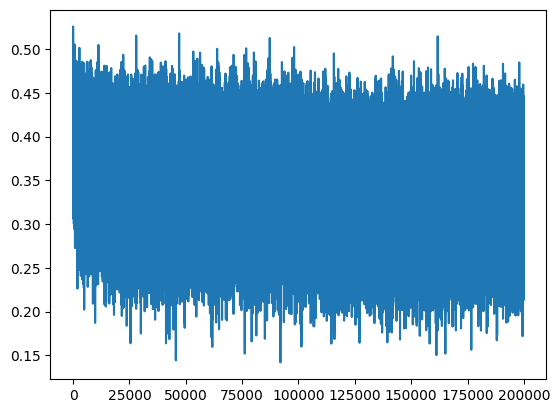

In [82]:
plt.plot(losses)

In [ ]:
# Calibrate the batch norm at the end of training
# NN trained with batch norm will expect batches of samples as input for prediction. 
# To be able to pass a single example to forward pass during prediction, we need to calibrate the batch norm at the end of training.
# This is done by calculating the mean and std of the hidden states.
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # we did this so that we can pass a single example to forward pass during prediction
#     bmean = hpreact.mean(dim=0, keepdim = True)
#     bstd = hpreact.std(dim=0, keepdim = True)

In [83]:
@torch.no_grad() # When we want to disable gradient tracking
def split_loss_bn(split:str) -> tuple[str, float]:
    X,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test':(Xtest, Ytest)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - bmean_running)/bstd_running) + bnbias # we did this so that we can pass a single example to forward pass during prediction
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())
split_loss_bn('train'), split_loss_bn('val')

(('train', 2.1274819374084473), ('val', 2.3939671516418457))

# Pytorchifying the code and training a deeper NN
- Making the code similar to what we will implement using pytorch

In [84]:
g = torch.Generator().manual_seed(2147483647)

In [259]:
## Definining a Linear Layer
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [260]:
## Defining a batch norm 1d layer
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (training with running 'momentum update': mean and std)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        # if we 're training, we calculate mean and std of the batch
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True) # calculate variance because we want to add epsilon(error term) to it to calculate our preactivations
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta # gamma: gain, beta: bias
        
        # update buffers if training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta] # Note: we don't add buffers here as we don't want to train them. They are updated internally in forward pass and not with gradients

In [261]:
## Defininig tanh activation function
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

##### Now that everything is a layer, it's easy to stack them up

In [31]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = 27
block_size = 3

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix
layers = [
    Linear(n_embed*block_size, n_hidden),Tanh(), # input layer
    Linear(n_hidden, n_hidden),Tanh(), # hidden layer 1
    Linear(n_hidden, n_hidden),Tanh(), # hidden layer 2
    Linear(n_hidden, n_hidden),Tanh(), # hidden layer 3
    Linear(n_hidden, n_hidden),Tanh(), # hidden layer 4
    Linear(n_hidden, vocab_size), # output layer
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *=0.1
    
    # for all other layers, apply gain of 5/3
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

number of parameters: 46497


In [32]:
max_steps = 200000
batch_size = 32
losses = []
ud = []

In [33]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # --- backward pass ---
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
   
    # --- LR update schedule ---
    lr  = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad
    
    # --- track stats ---
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    
    # if i>1000:
    #     break

      0/ 200000: 3.3066
  10000/ 200000: 2.3485
  20000/ 200000: 1.8252


KeyboardInterrupt: 

Layer 1 Tanh.%10s: mean -0.0745, std 0.7656, %saturation: 21.69%
Layer 3 Tanh.%10s: mean 0.0025, std 0.7217, %saturation: 12.50%
Layer 5 Tanh.%10s: mean -0.0052, std 0.7384, %saturation: 13.72%
Layer 7 Tanh.%10s: mean -0.0015, std 0.7203, %saturation: 12.12%
Layer 9 Tanh.%10s: mean -0.0164, std 0.7039, %saturation: 10.81%


Text(0.5, 1.0, 'Activation distribution')

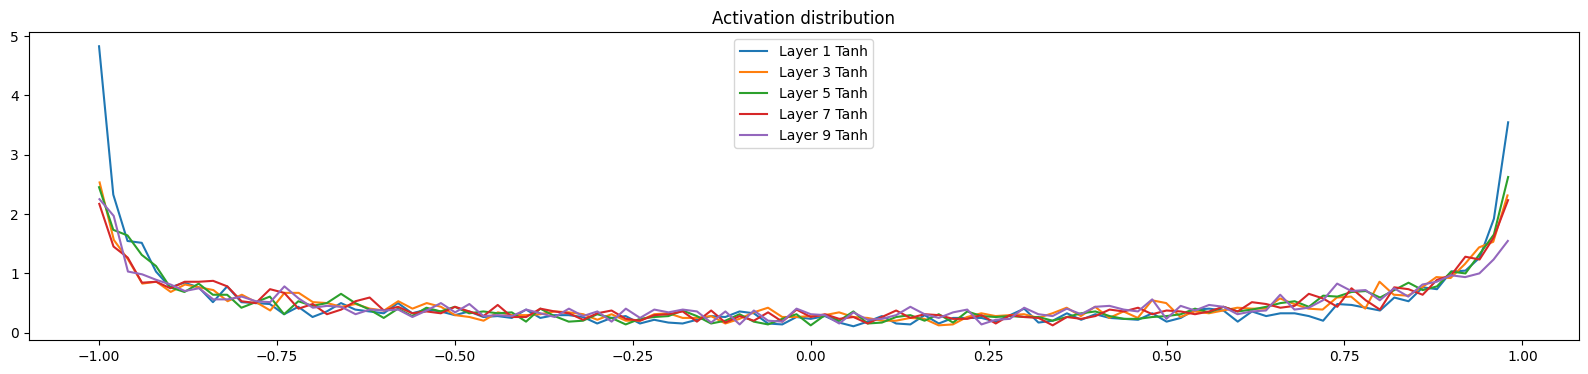

In [ ]:
# visualise histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i} {layer.__class__.__name__}.%10s: mean {t.mean():.4f}, std {t.std():.4f}, %saturation: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

Layer 1 Tanh.%10s: mean 0.0, std 3.4364e-03
Layer 3 Tanh.%10s: mean -0.0, std 3.4040e-03
Layer 5 Tanh.%10s: mean 0.0, std 3.3055e-03
Layer 7 Tanh.%10s: mean 0.0, std 3.1323e-03
Layer 9 Tanh.%10s: mean -0.0, std 2.4880e-03


Text(0.5, 1.0, 'Activation distribution')

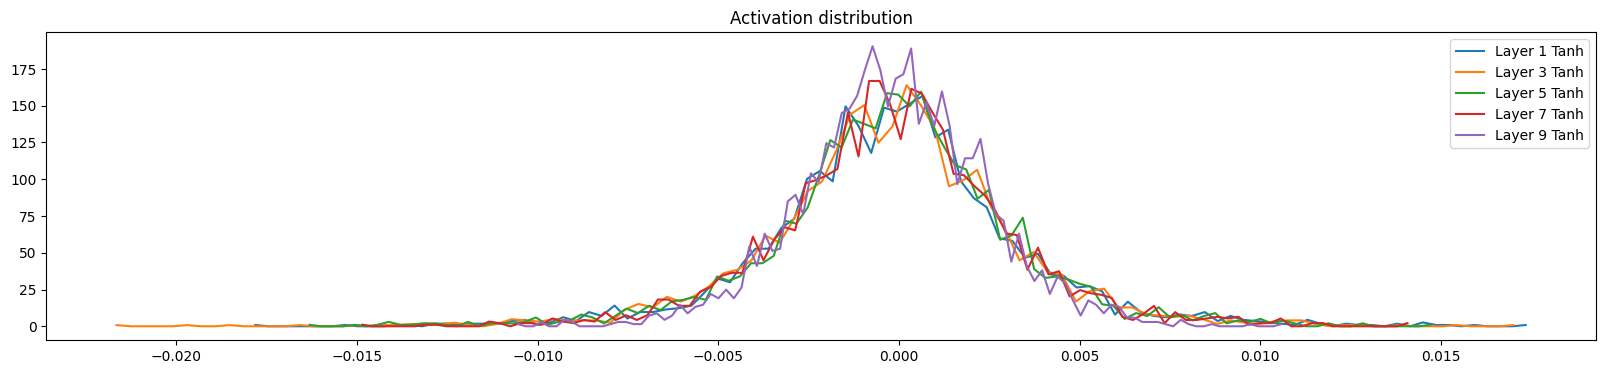

In [ ]:
# visualise histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer {i} {layer.__class__.__name__}.%10s: mean {t.mean():.1f}, std {t.std():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

weight (27, 10) | mean: 0.000132, std: 1.2e-02, grad:data ratio: 0.008847
weight (30, 100) | mean: -0.000154, std: 1.0e-02, grad:data ratio: 0.031253
weight (100, 100) | mean: -0.000097, std: 8.9e-03, grad:data ratio: 0.052268
weight (100, 100) | mean: -0.000012, std: 7.9e-03, grad:data ratio: 0.043996
weight (100, 100) | mean: 0.000011, std: 7.6e-03, grad:data ratio: 0.042977
weight (100, 100) | mean: -0.000024, std: 5.9e-03, grad:data ratio: 0.034282
weight (100, 27) | mean: 0.000000, std: 2.2e-02, grad:data ratio: 0.266868


Text(0.5, 1.0, 'Weight Gradient distribution')

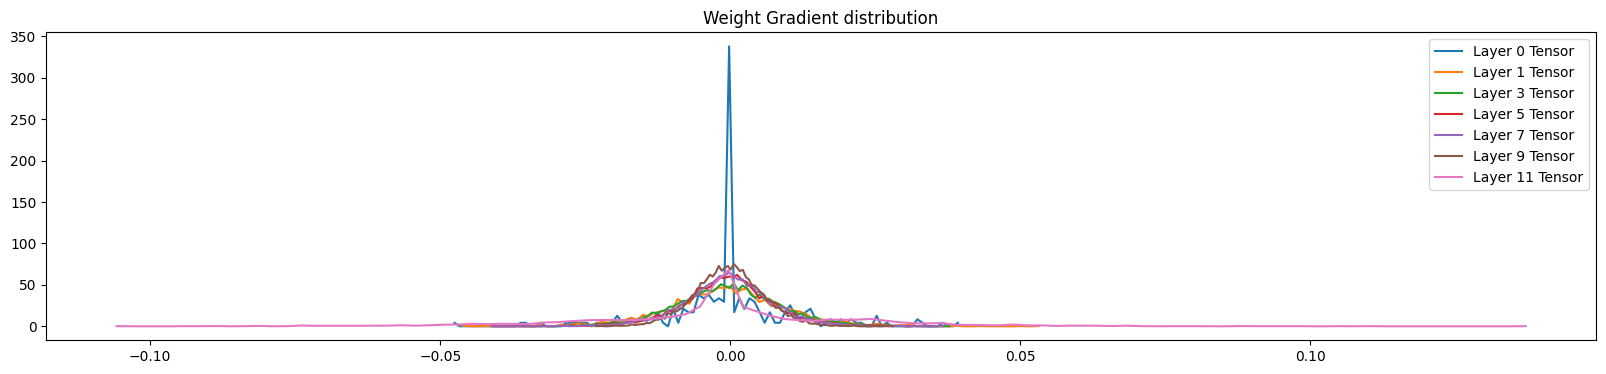

In [ ]:
# visualize histograms for gradient to data ratio (how big/small the gradient is compared to the data)
plt.figure(figsize = (20,4))
legends= []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {tuple(p.shape)} | mean: {t.mean():f}, std: {t.std():.1e}, grad:data ratio: {t.abs().mean()/p.abs().mean():f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {p.__class__.__name__}')
plt.legend(legends)
plt.title('Weight Gradient distribution')

## More informative plot: Gradient update to data ratio
- If the values are below -3, it means the parameters aren't trained fast enough.

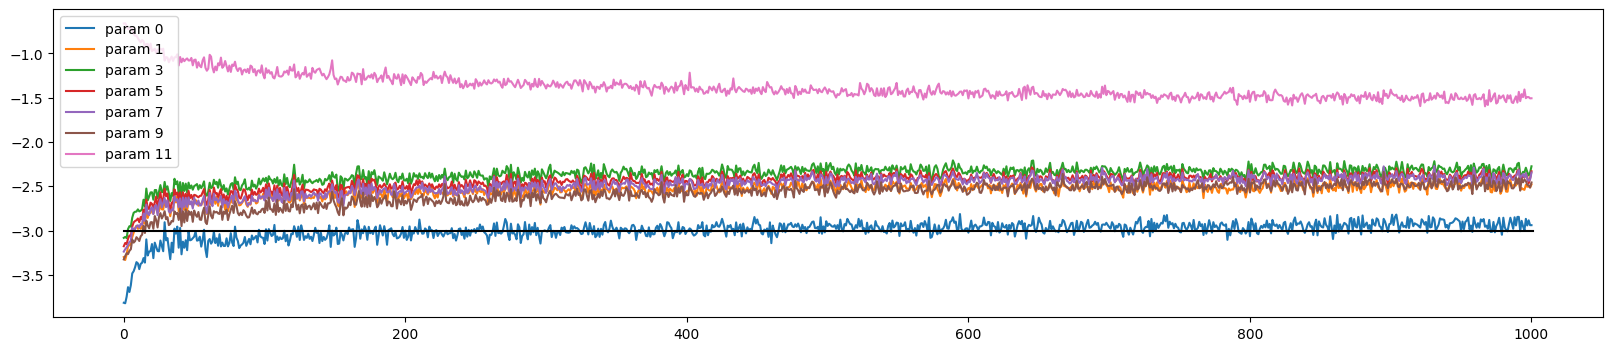

In [ ]:
## gradient update ratio
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)

# Re-introducting batch norm:

In [34]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
block_size = 3

C = torch.randn((vocab_size, n_embed),            generator=g)
layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embed * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [35]:
max_steps = 200000
batch_size = 32
losses = []
ud = []

In [36]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # --- backward pass ---
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
   
    # --- LR update schedule ---
    lr  = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad
    
    # --- track stats ---
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    # if i>=1000:
    #     break

      0/ 200000: 3.2896
  10000/ 200000: 2.4361
  20000/ 200000: 1.9636
  30000/ 200000: 2.3014
  40000/ 200000: 1.6611
  50000/ 200000: 2.3365
  60000/ 200000: 1.9500
  70000/ 200000: 2.2587
  80000/ 200000: 1.6284
  90000/ 200000: 1.8376
 100000/ 200000: 2.0875
 110000/ 200000: 2.2005
 120000/ 200000: 2.0344
 130000/ 200000: 1.6091
 140000/ 200000: 2.0974
 150000/ 200000: 1.8917
 160000/ 200000: 1.9554
 170000/ 200000: 1.8258
 180000/ 200000: 1.9924
 190000/ 200000: 1.8789


Layer 2 Tanh.%10s: mean -0.0079, std 0.6973, %saturation: 15.69%
Layer 5 Tanh.%10s: mean 0.0077, std 0.7393, %saturation: 19.06%
Layer 8 Tanh.%10s: mean -0.0060, std 0.7616, %saturation: 18.56%
Layer 11 Tanh.%10s: mean -0.0113, std 0.7792, %saturation: 17.75%
Layer 14 Tanh.%10s: mean -0.0182, std 0.7779, %saturation: 19.56%


Text(0.5, 1.0, 'Activation distribution')

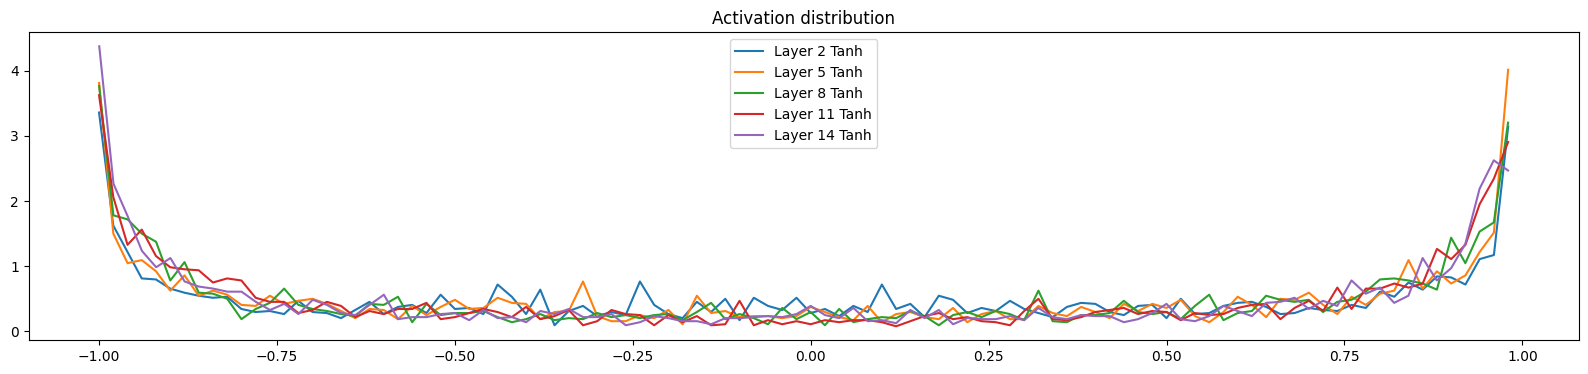

In [37]:
# visualise histograms for activations
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i} {layer.__class__.__name__}.%10s: mean {t.mean():.4f}, std {t.std():.4f}, %saturation: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

Layer 2 Tanh.%10s: mean -0.0, std 3.0490e-03
Layer 5 Tanh.%10s: mean -0.0, std 2.8822e-03
Layer 8 Tanh.%10s: mean -0.0, std 2.7501e-03
Layer 11 Tanh.%10s: mean 0.0, std 2.7948e-03
Layer 14 Tanh.%10s: mean 0.0, std 3.1179e-03


Text(0.5, 1.0, 'Activation distribution')

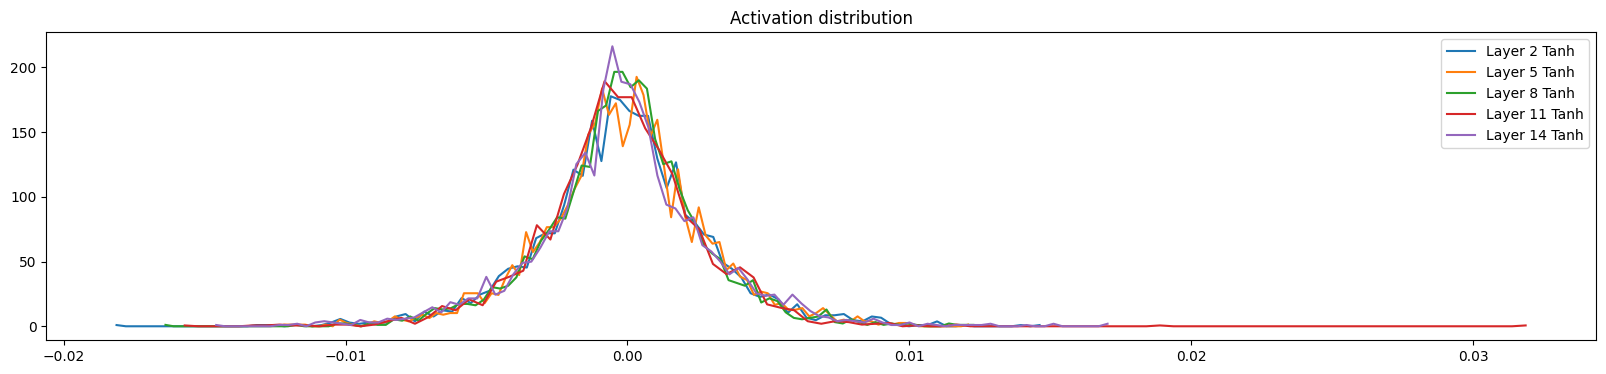

In [38]:
# visualise histograms for gradients
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer {i} {layer.__class__.__name__}.%10s: mean {t.mean():.1f}, std {t.std():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

weight (27, 10) | mean: 0.000000, std: 1.4e-02, grad:data ratio: 0.008563
weight (30, 100) | mean: 0.000065, std: 7.9e-03, grad:data ratio: 0.020399
weight (100, 100) | mean: 0.000016, std: 4.9e-03, grad:data ratio: 0.022242
weight (100, 100) | mean: -0.000130, std: 5.1e-03, grad:data ratio: 0.023660
weight (100, 100) | mean: 0.000023, std: 5.0e-03, grad:data ratio: 0.024441
weight (100, 100) | mean: 0.000055, std: 4.6e-03, grad:data ratio: 0.023490
weight (100, 27) | mean: -0.000009, std: 7.6e-03, grad:data ratio: 0.020498


Text(0.5, 1.0, 'Weight Gradient distribution')

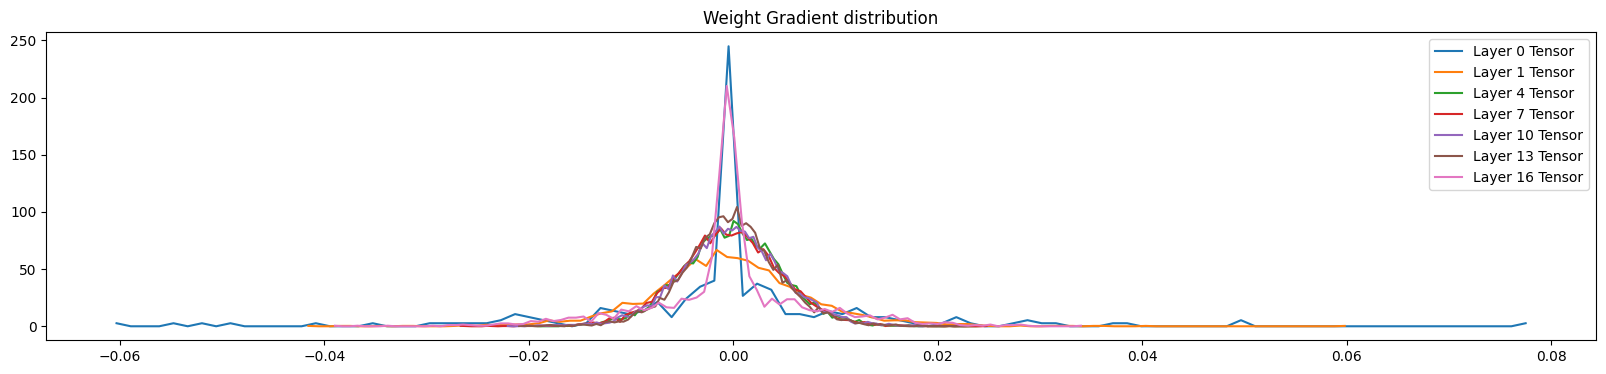

In [39]:
# visualize histograms for gradient to data ratio (how big/small the gradient is compared to the data)
plt.figure(figsize = (20,4))
legends= []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {tuple(p.shape)} | mean: {t.mean():f}, std: {t.std():.1e}, grad:data ratio: {t.abs().mean()/p.abs().mean():f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {p.__class__.__name__}')
plt.legend(legends)
plt.title('Weight Gradient distribution')

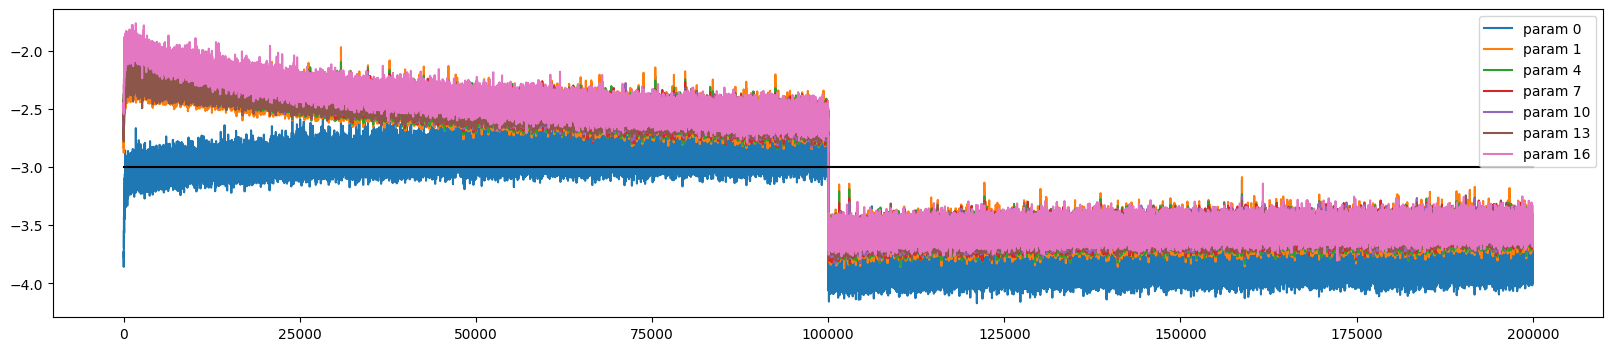

In [40]:
## gradient update ratio
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)

### IMP: Don't forget to put you network in eval mode to predict 

In [ ]:
# put layers into eval mode
for layer in layers:
  layer.training = False

In [ ]:
@torch.no_grad() # When we want to disable gradient tracking
def split_loss_bn(split:str) -> tuple[str, float]:
    X,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test':(Xtest, Ytest)
    }[split]
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    return (split, loss.item())

split_loss_bn('train'), split_loss_bn('val')

(('train', 1.9649927616119385), ('val', 2.3026814460754395))

In [42]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors

      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carman.
amelle.
khyrmin.
reigh.
skanya.
eja.
hutn.
deliah.
jareei.
nellara.
chaiivia.
leggydham.
join.
quintis.
lilea.
jadbi.
waterri.
jaryxi.
jace.
pirsa.
